In [98]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

In [99]:
triplets_file = '10000.txt'
songs_metadata_file = 'song_data.csv'

In [100]:
song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

In [101]:
song_df_2=pandas.read_csv(songs_metadata_file)
song_df=pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")
song_df.to_csv('song_df.csv')

In [102]:
len(song_df)

2000000

In [103]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [104]:
song_df['song'] = song_df['title'].map(str)+"-"+song_df['artist_name']

In [105]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
7127,Sehr kosmisch-Harmonia,8277,0.41385
9084,Undo-Björk,7032,0.35160
2068,Dog Days Are Over (Radio Edit)-Florence + The ...,6949,0.34745
9877,You're The One-Dwight Yoakam,6412,0.32060
6774,Revelry-Kings Of Leon,6145,0.30725
...,...,...,...
3526,Historia Del Portero-Ricardo Arjona,51,0.00255
7072,Scared-Three Days Grace,51,0.00255
2147,Don´t Leave Me Now-Amparanoia,50,0.00250
2991,Ghosts (Toxic Avenger Mix)-Ladytron,48,0.00240


In [106]:
users = song_df['user_id'].unique()
len(users) 

76353

In [107]:
songs = song_df['song'].unique()
len(songs)

9953

In [108]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove-Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,Entre Dos Aguas-Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,Stronger-Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,Constellations-Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly-Foo Fighters


In [109]:
song_df=song_df.iloc[0:20000]
len(song_df)

20000

In [110]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)

In [111]:
len(train_data)

16000

In [112]:
#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        return user_items
        
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
        return item_users
        
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())   
        return all_items
        
    def construct_cooccurence_matrix(self, user_songs, all_songs):
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)

        for i in range(0,len(all_songs)):
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                users_j = user_songs_users[j]
                users_intersection = users_i.intersection(users_j)
                if len(users_intersection) != 0:
                    users_union = users_i.union(users_j)
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        return cooccurence_matrix


    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
        columns = ['user_id', 'song', 'score', 'rank']
        df = pandas.DataFrame(columns=columns)
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1

        if df.shape[0] == 0:
            print("The current user has no songs to be recommended")
            return -1
        else:
            return df
 
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    def recommend(self, user):
        user_songs = self.get_user_items(user)    
        print("No. of unique songs for the user: %d" % len(user_songs))
        all_songs = self.get_all_items_train_data()
        print("no. of unique songs in the training set: %d" % len(all_songs))
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
        return df_recommendations

    def get_similar_items(self, item_list):
        user_songs = item_list
        all_songs = self.get_all_items_train_data()
        print("no. of unique songs in the training set: %d" % len(all_songs))
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
        return df_recommendations

In [113]:
is_model = item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

In [114]:
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
print("For userid: %s:" % user_id)

For userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:


In [115]:
is_model.recommend(user_id)

No. of unique songs for the user: 13
no. of unique songs in the training set: 6574
Non zero values in cooccurence_matrix :4098


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird-Eminem,0.052260,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Heartbreak Warfare-John Mayer,0.050858,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman-Eminem / Dina Rae,0.050789,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,One Time-Justin Bieber,0.050047,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile-Justin Bieber,0.046741,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Te Amo-Rihanna,0.044500,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Eenie Meenie-Sean Kingston and Justin Bieber,0.044160,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Paper Planes-M.I.A.,0.043189,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Terre Promise-O'Rosko Raricim,0.042895,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Brave The Elements-Colossal,0.042287,10


In [116]:
#Class to calculate precision and recall
import random
class precision_recall_calculator():
    def __init__(self, test_data, train_data, is_model):
        self.test_data = test_data
        self.train_data = train_data
        self.user_test_sample = None
        self.model2 = is_model
        self.ism_training_dict = dict()
        self.test_dict = dict()
    
    #Method to return random percentage of values from a list
    def remove_percentage(self, list_a, percentage):
        k = int(len(list_a) * percentage)
        random.seed(0)
        indicies = random.sample(range(len(list_a)), k)
        new_list = [list_a[i] for i in indicies]
    
        return new_list
    
    #Create a test sample of users for use in calculating precision
    #and recall
    def create_user_test_sample(self, percentage):
        users_test_and_training = list(set(self.test_data['user_id'].unique()).intersection(set(self.train_data['user_id'].unique())))
        print("Length of user_test_and_training:%d" % len(users_test_and_training))
        self.users_test_sample = self.remove_percentage(users_test_and_training, percentage)

        print("Length of user sample:%d" % len(self.users_test_sample))

    def get_test_sample_recommendations(self):

        for user_id in self.users_test_sample:
            print("Getting recommendations for user:%s" % user_id)
            user_sim_items = self.model2.recommend(user_id)
            self.ism_training_dict[user_id] = list(user_sim_items["song"])
            test_data_user = self.test_data[self.test_data['user_id'] == user_id]
            self.test_dict[user_id] = set(test_data_user['song'].unique() )
    
    def calculate_precision_recall(self):
        cutoff_list = list(range(1,11))
        ism_avg_precision_list = []
        ism_avg_recall_list = []


        num_users_sample = len(self.users_test_sample)
        for N in cutoff_list:
            ism_sum_precision = 0
            ism_sum_recall = 0

            ism_avg_precision = 0
            ism_avg_recall = 0


            for user_id in self.users_test_sample:
                ism_hitset = self.test_dict[user_id].intersection(set(self.ism_training_dict[user_id][0:N]))
                testset = self.test_dict[user_id]
                ism_sum_precision += float(len(ism_hitset))/float(len(testset))
                ism_sum_recall += float(len(ism_hitset))/float(N)
    
            ism_avg_precision = ism_sum_precision/float(num_users_sample)
            ism_avg_recall = ism_sum_recall/float(num_users_sample)
            ism_avg_precision_list.append(ism_avg_precision)
            ism_avg_recall_list.append(ism_avg_recall)
        return (ism_avg_precision_list, ism_avg_recall_list)
    
    def calculate_measures(self, percentage):
        #Create a test sample of users
        self.create_user_test_sample(percentage)
        self.get_test_sample_recommendations()
        return self.calculate_precision_recall()

In [117]:
import time
start = time.time()
user_sample = 0.05
pr = precision_recall_calculator(test_data, train_data, is_model)
(ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)
end = time.time()
print(end - start)

Length of user_test_and_training:671
Length of user sample:33
Getting recommendations for user:8e8b32a1621d2950fe9a6384d8fb594fd25525df
No. of unique songs for the user: 167
no. of unique songs in the training set: 6574
Non zero values in cooccurence_matrix :44489
Getting recommendations for user:7822f4f6c7b830abf9ba48c4b7dad7e9175d052d
No. of unique songs for the user: 12
no. of unique songs in the training set: 6574
Non zero values in cooccurence_matrix :1464
Getting recommendations for user:99c8f28e3349b5e1e719995a008912b108126f3c
No. of unique songs for the user: 7
no. of unique songs in the training set: 6574
Non zero values in cooccurence_matrix :600
Getting recommendations for user:5e2ba12ad8f80f03471efdab6ac7d4b1734773ae
No. of unique songs for the user: 3
no. of unique songs in the training set: 6574
Non zero values in cooccurence_matrix :32
Getting recommendations for user:f4c7c7eb3c53d3280baa28aed1506775f28812d3
No. of unique songs for the user: 12
no. of unique songs in the

In [120]:
import pylab as pl
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()

Plotting precision recall curves.


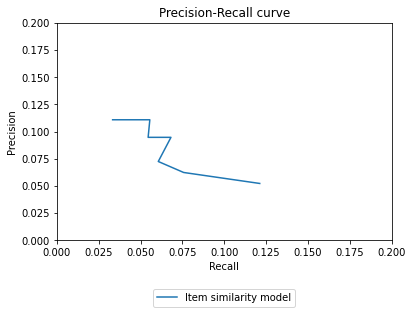

In [121]:
print("Plotting precision recall curves.")
plot_precision_recall(ism_avg_precision_list, ism_avg_recall_list, "Item similarity model")